### Step a-b: create the base model
Questions: You want to implement a masking intervention in a simple compartmental model and simulate epidemic trajectories under different compliance scenarios. You found an existing model that incorporates masking as a time-dependent modification to the β parameter (https://doi.org/10.3390/ijerph18179027 plus accompanying code), and you want to ensure that the model is working as expected by reproducing plots in the publication. 

Replicate an analysis from the paper.
- (TA1 Model Extraction Workflow, TA2 Model Representation) Extract the SEIRD model (equations 1-5, with time-varying β as defined in equations 8-9) and load into the workbench. In equation 8, let kappa = γR0, R0 = 5. In equation 9, let k = 5.

- (TA3 Simulation Workflow, Unit Test): Replicate Figure 3 from the paper, which maps to the first scenario in the paper- implementing a masking intervention at several different timepoints (delays of 0 days, 50 days, 100 days, and control case, from the date of first infection) in the pandemic, with 100% compliance. Recreate the Fig. 3 curves (including peak infection times and levels), up to some reasonable margin of error.  

In [279]:
import sympy
import itertools
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling.viz import GraphicalModel

In [280]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}


parameters = {
    'gamma': Parameter(name='gamma', value=1/11, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/5, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=0.000064, units=dimensionless_units()),
    'rho': Parameter(name='rho', value=1/9, units=per_day_units()),
    'N': Parameter(name='N', value=5_600_000, units=person_units()),
    'beta_s': Parameter(name='beta_s', value=1, units=per_day_units()),
    'beta_c': Parameter(name='beta_c', value=0.4, units=per_day_units()),
    't_0': Parameter(name='t_0', value=89, unts=day_units, units=day_units()),
    # D=11, gamma = 1/D, R_0 = 5 and
    # beta = R_0 * gamma * mask(t) so kappa = 5/11
    'kappa': Parameter(name='kappa', value=5/11, units=per_day_units()),
    'k': Parameter(name='k', value=5.0, units=dimensionless_units()),
}

initials = {
    'S': Initial(concept=Concept(name='S'), expression=5_600_000-1.0),
    'E': Initial(concept=Concept(name='E'), expression=1.0),
    'I': Initial(concept=Concept(name='I'), expression=0.0),
    'R': Initial(concept=Concept(name='R'), expression=0.0),
    'D': Initial(concept=Concept(name='D'), expression=0.0),
}

In [281]:
S, E, I, R, D, N, kappa, beta_s, beta_c, k, t_0, t, alpha, delta, rho, gamma = \
    sympy.symbols('S E I R D N kappa beta_s beta_c k t_0 t alpha delta rho gamma')

observables = {
    'infected': Observable(name='infected', expression=SympyExprStr(I))
}

In [282]:
m_1 = (beta_s - beta_c) / (1 + sympy.exp(-k*(t_0-t))) + beta_c
beta = kappa*m_1

t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta / N)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=delta*E)
t3 = NaturalConversion(subject=c['I'],
                       outcome=c['R'],
                       rate_law=(1-alpha)*gamma*I)
t4 = NaturalConversion(subject=c['I'],
                       outcome=c['D'],
                       rate_law=alpha*rho*I)
templates = [t1, t2, t3, t4]
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 1a')
)
AMRPetriNetModel(Model(tm)).to_json_file('scenario1_a.json')
tm.observables

{'infected': Observable(name='infected', display_name=None, description=None, identifiers={}, context={}, units=None, expression=I)}

### Step c: update beta

(TA2 Model Modification Workflow, TA3 Simulation Workflow): Update the β(t) function to be defined as equations 8 and 10, with k1 = 5, and k2 = 1. This reflects the paper’s second scenario, gradual noncompliance with the masking policy over time. Rerun the simulation with several different delays in enforcing a mask policy (ranging from 0 to 140 days), and replicate Fig. 5, up to some reasonable margin of error.

In [283]:
k_1, k_2, t_1, beta_nc = sympy.symbols('k_1 k_2 t_1 beta_nc')
parameters['k_1'] = Parameter(name='k_1', value=5.0, units=dimensionless_units())
parameters['k_2'] = Parameter(name='k_2', value=1.0, units=dimensionless_units())
parameters['t_1'] = Parameter(name='t_1', value=154, units=day_units())
parameters['beta_nc'] = Parameter(name='beta_nc', value=0.5, units=per_day_units())
tm.parameters = parameters
tm.annotations = Annotations(name='Scenario 1c')
m_2 = (beta_s - beta_c) / (1 + sympy.exp(-k_1*(t_0-t))) + (beta_c - beta_nc) / (1 + sympy.exp(-k_2*(t_1-t))) + beta_nc

In [284]:
t1.rate_law = SympyExprStr(S*I*kappa*m_2/N)

In [285]:
t1.rate_law.args[0]

I*S*kappa*(beta_nc + (beta_c - beta_nc)/(1 + exp(-k_2*(-t + t_1))) + (-beta_c + beta_s)/(1 + exp(-k_1*(-t + t_0))))/N

In [286]:
AMRPetriNetModel(Model(tm)).to_json_file('scenario1_c.json')

### Step d: update for reinfection
(TA2 Model Modification Workflow, TA3 Simulation Workflow): Update the system of equations to include equations 6 and 7. This adds the potential for reinfection. Compare with the outcomes from 1c. What impact does immunity loss and potential for reinfection have?

In [287]:
epsilon = sympy.Symbol('epsilon')
parameters['epsilon'] = Parameter(name='epsilon', value=1/90, units=per_day_units())
tm.parameters = parameters
tm.annotations = Annotations(name='Scenario 1d')
t5 = NaturalConversion(subject=c['R'],
                       outcome=c['S'],
                       rate_law=epsilon*R)
tm.templates.append(t5)

In [288]:
AMRPetriNetModel(Model(tm)).to_json_file('scenario1_d.json')
tm.parameters

{'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.09090909090909091, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.2, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=6.4e-05, distribution=None),
 'rho': Parameter(name='rho', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.1111111111111111, distribution=None),
 'N': Parameter(name='N', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=person), value=5600000.0, distribution=None),
 'beta_s': Parameter(name='beta_s', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=1.0, distribution=None),
 'beta_c': P

## Demo unit normalization

In [289]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
tm_norm = counts_to_dimensionless(tm, 'person', 5_600_000)

In [291]:
tm_norm.initials

{'S': Initial(concept=Concept(name='S', display_name=None, description=None, identifiers={}, context={}, units=None), expression=0.999999821428571),
 'E': Initial(concept=Concept(name='E', display_name=None, description=None, identifiers={}, context={}, units=None), expression=1.78571428571429e-7),
 'I': Initial(concept=Concept(name='I', display_name=None, description=None, identifiers={}, context={}, units=None), expression=0),
 'R': Initial(concept=Concept(name='R', display_name=None, description=None, identifiers={}, context={}, units=None), expression=0),
 'D': Initial(concept=Concept(name='D', display_name=None, description=None, identifiers={}, context={}, units=None), expression=0)}

In [292]:
tm_norm.parameters

{'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.09090909090909091, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.2, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=6.4e-05, distribution=None),
 'rho': Parameter(name='rho', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.1111111111111111, distribution=None),
 'N': Parameter(name='N', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1), value=1.0, distribution=None),
 'beta_s': Parameter(name='beta_s', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=1.0, distribution=None),
 'beta_c': Parameter(na

In [293]:
tm_norm.templates

[ControlledConversion(rate_law=I*S*kappa*(beta_nc + (beta_c - beta_nc)/(1 + exp(-k_2*(-t + t_1))) + (-beta_c + beta_s)/(1 + exp(-k_1*(-t + t_0))))/N, name=None, display_name=None, type='ControlledConversion', controller=Concept(name='I', display_name=None, description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=1)), subject=Concept(name='S', display_name=None, description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=1)), outcome=Concept(name='E', display_name=None, description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=1)), provenance=[]),
 NaturalConversion(rate_law=E*delta, name=None, display_name=None, type='NaturalConversion', subject=Concept(name='E', display_name=None, description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=1)), outcome=Concept(name='I', display_name=None, description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=1)),

In [294]:
AMRPetriNetModel(Model(tm_norm)).to_json_file('scenario1_d_normalized.json')

## Part 2 c
c)	(TA2 Model Modification Workflow) Extend the core model extracted in Problem 1 of this scenario, by adding age stratification, new compartments (e.g., representing diagnosed/undiagnosed individuals), and vaccination, while maintaining the time-varying transmission aspects of the original model. Ensure that the functionality to extend an extracted model is available in the workbench.

### Stratify by age

In [295]:
tm_age = stratify(tm_norm,
                  key='age',
                  strata=['young', 'middle_aged', 'old'],
                  structure=[],
                  cartesian_control=True,
                  params_to_stratify={'kappa'})
tm_age.annotations.name = 'Scenario 1 age stratified'
AMRPetriNetModel(Model(tm_age)).to_json_file('scenario1_2c_age.json')
tm_age.observables

{'infected': Observable(name='infected', display_name=None, description=None, identifiers={}, context={}, units=None, expression=I_middle_aged + I_old + I_young)}

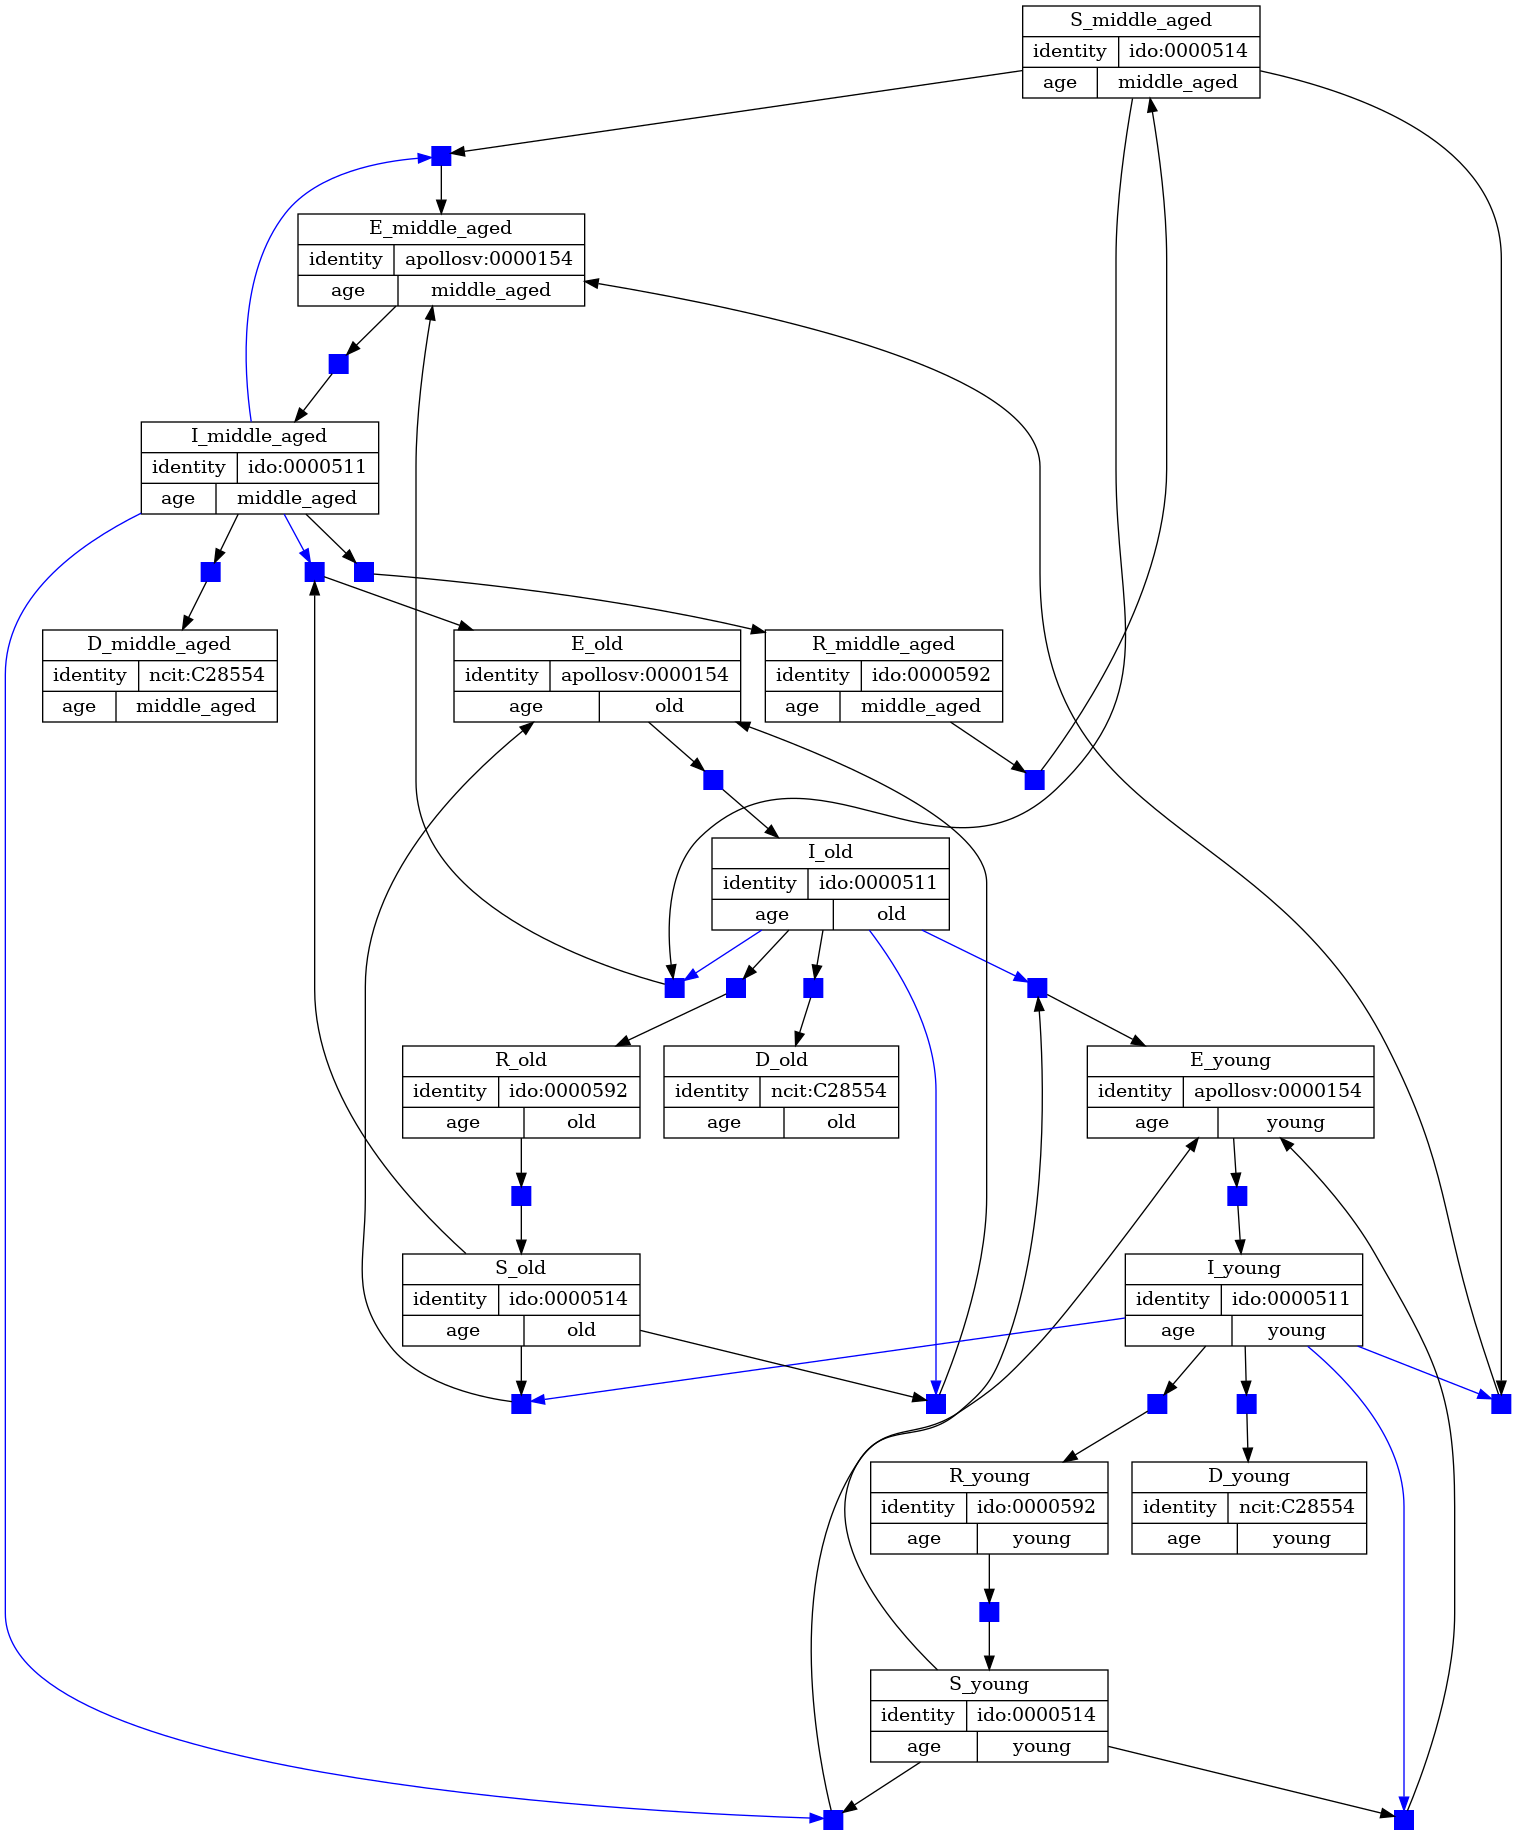

In [296]:
GraphicalModel.for_jupyter(tm_age)

### Stratify by diagnosis

In [297]:
tm_diag = stratify(tm_age,
                   key='diagnosis',
                   strata=['undiagnosed', 'diagnosed'],
                   structure=[['undiagnosed', 'diagnosed']],
                   directed=True,
                   concepts_to_stratify={'I_young', 'I_middle_aged', 'I_old'},
                   params_to_stratify={('kappa_%d' % i) for i in range(9)},
                   cartesian_control=False)
assert tm_diag.templates
tm_diag.annotations.name = 'Scenario 1 age/diagnosis stratified'
m = Model(tm_diag)
AMRPetriNetModel(Model(tm_diag)).to_json_file('scenario1_2c_age_diag.json')

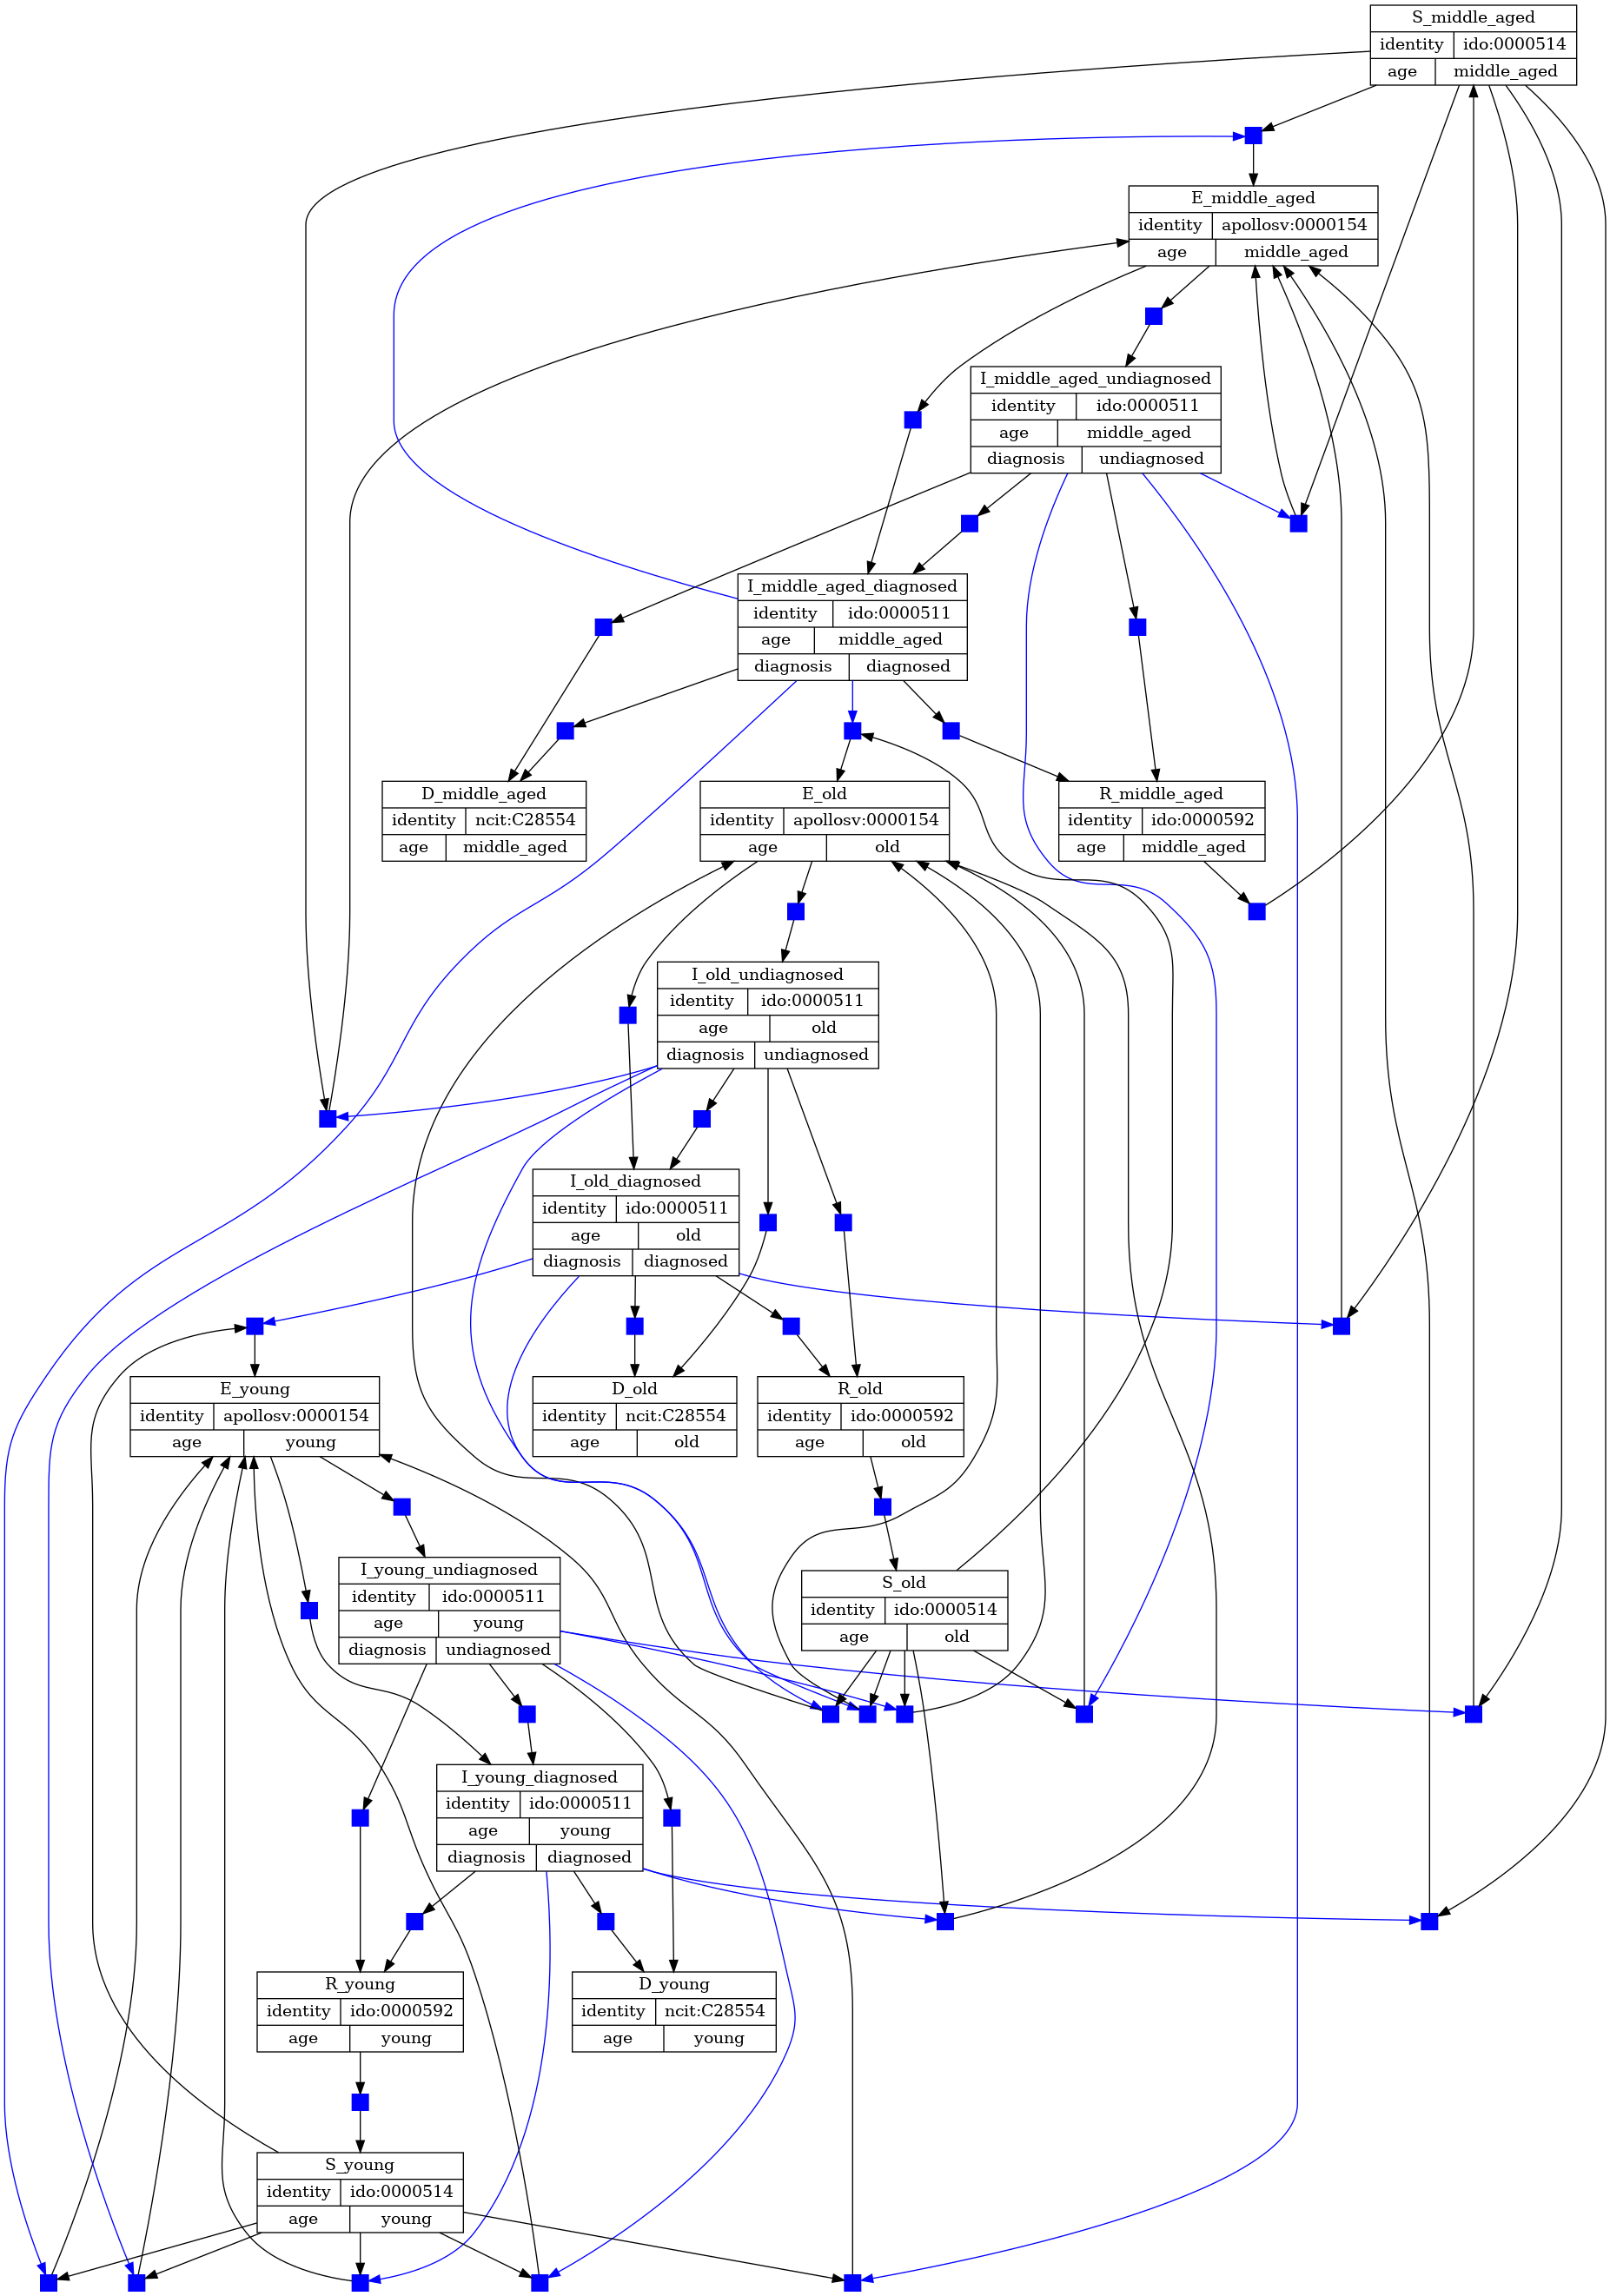

In [298]:
GraphicalModel.for_jupyter(tm_diag)

In [299]:
for v in m.variables.values():
    print(v.data['name'], v.data['expression'])

S_middle_aged SympyExprStr(SympyExprStr(0.999999821428571)/3)
I_middle_aged_diagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
E_middle_aged SympyExprStr(SympyExprStr(1.78571428571429e-7)/3)
I_middle_aged_undiagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_old_diagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_old_undiagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_young_diagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_young_undiagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
S_old SympyExprStr(SympyExprStr(0.999999821428571)/3)
E_old SympyExprStr(SympyExprStr(1.78571428571429e-7)/3)
S_young SympyExprStr(SympyExprStr(0.999999821428571)/3)
E_young SympyExprStr(SympyExprStr(1.78571428571429e-7)/3)
R_middle_aged SympyExprStr(SympyExprStr(0)/3)
R_old SympyExprStr(SympyExprStr(0)/3)
R_young SympyExprStr(SympyExprStr(0)/3)
D_middle_aged SympyExprStr(Sympy

In [300]:
for init in tm_diag.initials.values():
    print(init.concept.name, init.expression)

S_middle_aged SympyExprStr(SympyExprStr(0.999999821428571)/3)
S_old SympyExprStr(SympyExprStr(0.999999821428571)/3)
S_young SympyExprStr(SympyExprStr(0.999999821428571)/3)
E_middle_aged SympyExprStr(SympyExprStr(1.78571428571429e-7)/3)
E_old SympyExprStr(SympyExprStr(1.78571428571429e-7)/3)
E_young SympyExprStr(SympyExprStr(1.78571428571429e-7)/3)
I_middle_aged_diagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_middle_aged_undiagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_old_diagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_old_undiagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_young_diagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
I_young_undiagnosed SympyExprStr(SympyExprStr(SympyExprStr(SympyExprStr(0)/3))/2)
R_middle_aged SympyExprStr(SympyExprStr(0)/3)
R_old SympyExprStr(SympyExprStr(0)/3)
R_young SympyExprStr(SympyExprStr(0)/3)
D_middle_aged SympyExprStr(Sympy

### Stratify by vaccination status

In [301]:
tm_vax = stratify(tm_diag,
                  key='vax',
                  strata=['u', 'v'],
                  structure=[['u', 'v']],
                  directed=True,
                  cartesian_control=True,
                  params_to_stratify={'kappa_%d_%d' % (i, j) for i, j in itertools.product(range(9), range(2))},
                  concepts_to_preserve={'D_young', 'D_middle_aged', 'D_old'})
tm_vax.annotations.name = 'Scenario 1 age/diagnosis/vax stratified'
AMRPetriNetModel(Model(tm_vax)).to_json_file('scenario1_2c_age_diag_vax.json')

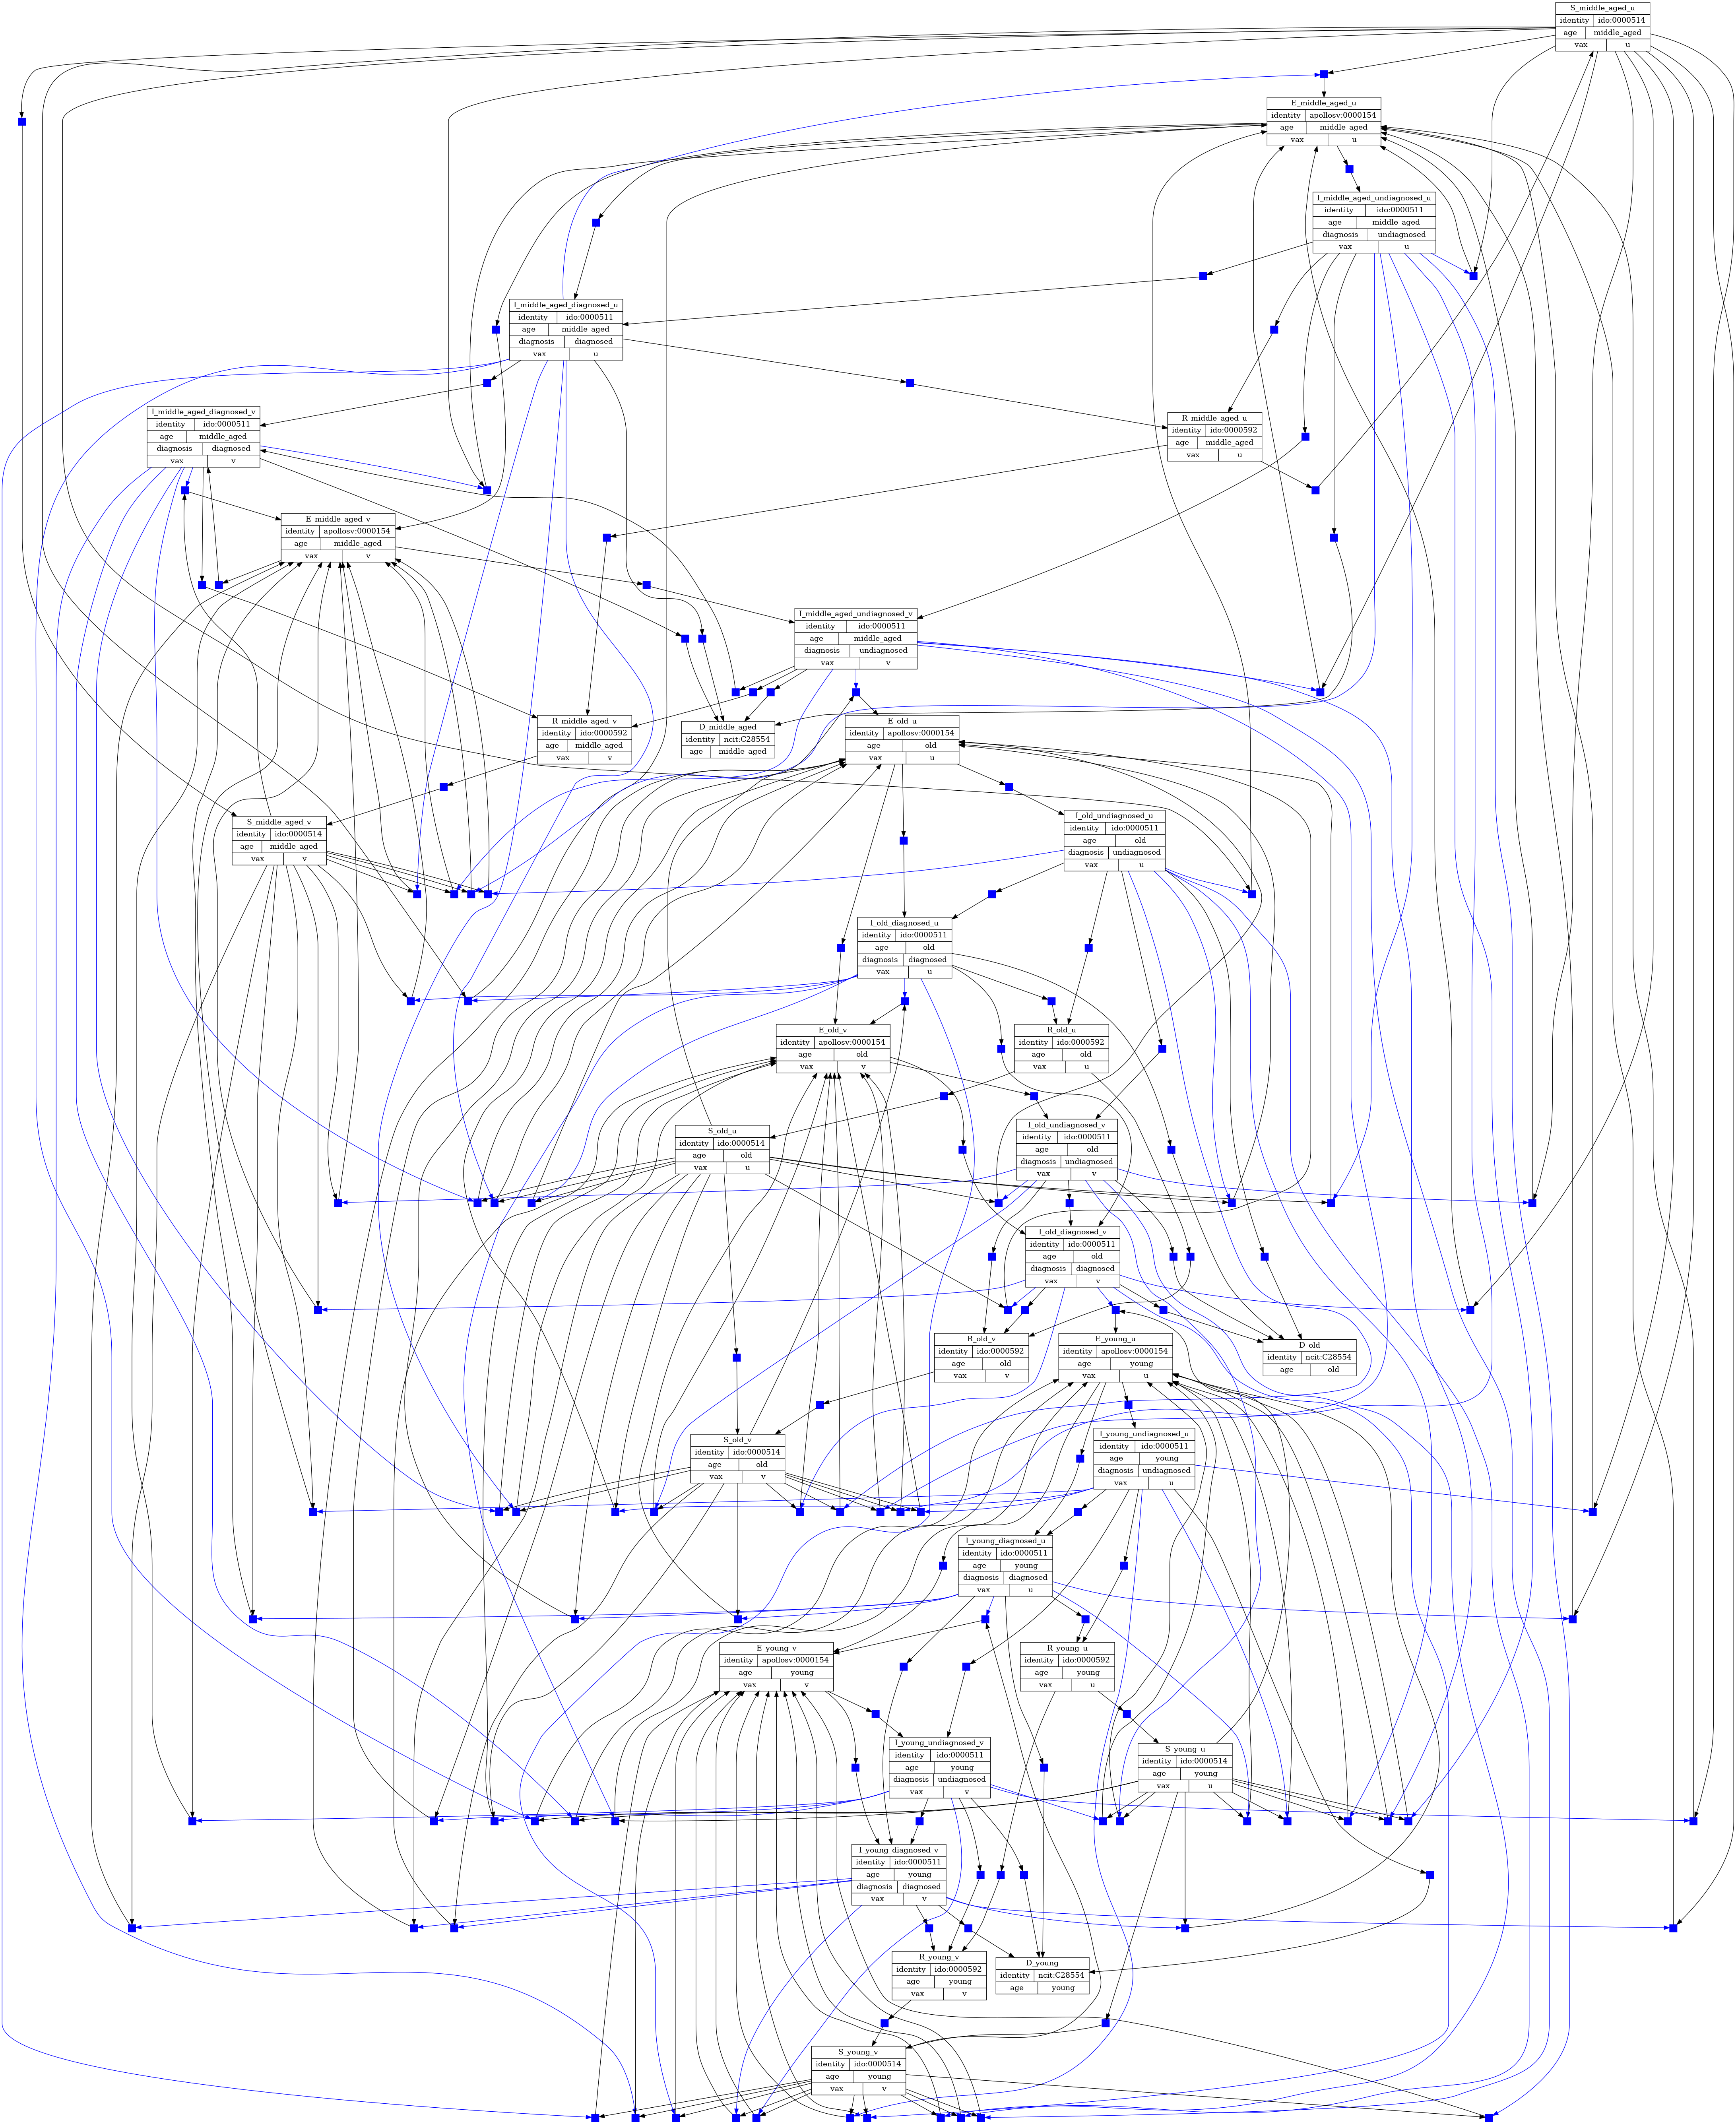

In [302]:
GraphicalModel.for_jupyter(tm_vax)

### Statistics of model size

In [303]:
import pandas as pd
data = [[m.annotations.name, len(m.templates), len(m.parameters)]
        for m in [tm_norm, tm_age, tm_diag, tm_vax]]
pd.DataFrame(data, columns=["Model", "#templates", "#params"])

Model  #templates  #params
0                              Scenario 1d           5       15
1                Scenario 1 age stratified          21       23
2      Scenario 1 age/diagnosis stratified          45       33
3  Scenario 1 age/diagnosis/vax stratified         141       88

### An example of a rate law after 3 rounds of stratification

In [304]:
tm_vax.templates[0].rate_law.args[0]

I_middle_aged_diagnosed_u*S_middle_aged_u*kappa_0_0_0*(beta_nc + (beta_c - beta_nc)/(1 + exp(-k_2*(-t + t_1))) + (-beta_c + beta_s)/(1 + exp(-k_1*(-t + t_0))))/N

### List of parameters after 3 rounds of stratification

In [305]:
pd.set_option('display.max_rows', None)
pd.DataFrame([[p.name, p.value] for p in tm_vax.parameters.values()], columns=['Name', 'Value'])

Name       Value
0                     gamma    0.090909
1                     delta    0.200000
2                     alpha    0.000064
3                       rho    0.111111
4                         N    1.000000
5                    beta_s    1.000000
6                    beta_c    0.400000
7                       t_0   89.000000
8               kappa_0_0_0    0.454545
9               kappa_0_0_1    0.454545
10              kappa_0_0_2    0.454545
11              kappa_0_0_3    0.454545
12              kappa_0_1_0    0.454545
13              kappa_0_1_1    0.454545
14              kappa_0_1_2    0.454545
15              kappa_0_1_3    0.454545
16              kappa_1_0_0    0.454545
17              kappa_1_0_1    0.454545
18              kappa_1_0_2    0.454545
19              kappa_1_0_3    0.454545
20              kappa_1_1_0    0.454545
21              kappa_1_1_1    0.454545
22              kappa_1_1_2    0.454545
23              kappa_1_1_3    0.454545
24              kappa_2_0_0    0.454545
25              kappa_2_0_1    0.454545
26              kappa_2_0_2    0.454545
27              kappa_2_0_3    0.454545
28              kappa_2_1_0    0.454545
29              kappa_2_1_1    0.454545
30              kappa_2_1_2    0.454545
31              kappa_2_1_3    0.454545
32              kappa_3_0_0    0.454545
33              kappa_3_0_1    0.454545
34              kappa_3_0_2    0.454545
35              kappa_3_0_3    0.454545
36              kappa_3_1_0    0.454545
37              kappa_3_1_1    0.454545
38              kappa_3_1_2    0.454545
39              kappa_3_1_3    0.454545
40              kappa_4_0_0    0.454545
41              kappa_4_0_1    0.454545
42              kappa_4_0_2    0.454545
43              kappa_4_0_3    0.454545
44              kappa_4_1_0    0.454545
45              kappa_4_1_1    0.454545
46              kappa_4_1_2    0.454545
47              kappa_4_1_3    0.454545
48              kappa_5_0_0    0.454545
49              kappa_5_0_1    0.454545
50              kappa_5_0_2    0.454545
51              kappa_5_0_3    0.454545
52              kappa_5_1_0    0.454545
53              kappa_5_1_1    0.454545
54              kappa_5_1_2    0.454545
55              kappa_5_1_3    0.454545
56              kappa_6_0_0    0.454545
57              kappa_6_0_1    0.454545
58              kappa_6_0_2    0.454545
59              kappa_6_0_3    0.454545
60              kappa_6_1_0    0.454545
61              kappa_6_1_1    0.454545
62              kappa_6_1_2    0.454545
63              kappa_6_1_3    0.454545
64              kappa_7_0_0    0.454545
65              kappa_7_0_1    0.454545
66              kappa_7_0_2    0.454545
67              kappa_7_0_3    0.454545
68              kappa_7_1_0    0.454545
69              kappa_7_1_1    0.454545
70              kappa_7_1_2    0.454545
71              kappa_7_1_3    0.454545
72              kappa_8_0_0    0.454545
73              kappa_8_0_1    0.454545
74              kappa_8_0_2    0.454545
75              kappa_8_0_3    0.454545
76              kappa_8_1_0    0.454545
77              kappa_8_1_1    0.454545
78              kappa_8_1_2    0.454545
79              kappa_8_1_3    0.454545
80                        k    5.000000
81                      k_1    5.000000
82                      k_2    1.000000
83                      t_1  154.000000
84                  beta_nc    0.500000
85                  epsilon    0.011111
86  p_undiagnosed_diagnosed    0.100000
87                    p_u_v    0.100000

### An observable after 3 rounds of stratification

In [306]:
tm_vax.observables['infected']

Observable(name='infected', display_name=None, description=None, identifiers={}, context={}, units=None, expression=I_middle_aged_diagnosed_u + I_middle_aged_diagnosed_v + I_middle_aged_undiagnosed_u + I_middle_aged_undiagnosed_v + I_old_diagnosed_u + I_old_diagnosed_v + I_old_undiagnosed_u + I_old_undiagnosed_v + I_young_diagnosed_u + I_young_diagnosed_v + I_young_undiagnosed_u + I_young_undiagnosed_v)

In [307]:
tm_vax.observables['infected'].expression.args[0]

I_middle_aged_diagnosed_u + I_middle_aged_diagnosed_v + I_middle_aged_undiagnosed_u + I_middle_aged_undiagnosed_v + I_old_diagnosed_u + I_old_diagnosed_v + I_old_undiagnosed_u + I_old_undiagnosed_v + I_young_diagnosed_u + I_young_diagnosed_v + I_young_undiagnosed_u + I_young_undiagnosed_v